# 1.Exploratory Data Analysis (EDA) - Battery State of Health (SOH) Project

Objective: This notebook performs comprehensive exploratory data analysis on the SiCWell Dataset to establish a foundation for battery State of Health (SOH) estimation and degradation analysis.

Scope:
- Understand battery checkup data structure and measurement protocols
- Identify and select specific cells (AC01 & AC02) for detailed analysis
- Investigate capacity degradation trends over sequential checkups
- Calculate and visualize State of Health (SOH) metrics

Dataset Source:
- Dataset Name: SiCWell Dataset
- Primary File: cell_checkup.zip (155.21 MB)
- Provider: IEEE DataPort
- Official URL: https://ieee-dataport.org/open-access/sicwell-dataset

## 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Global plotting style (clean, industry-like)
sns.set(style="whitegrid", context="talk")

# Figure base directory
FIG_DIR = Path("../figures")

# Subfolders
EDA_DIR = FIG_DIR / "eda"
DEG_DIR = FIG_DIR / "degradation"
MODEL_DIR = FIG_DIR / "modeling"

# Create folders if not exist
for d in [EDA_DIR, DEG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Figure directories ready")

Figure directories ready


## 1.2 Global Figure Configuration

In [23]:
# Global plotting style (clean, industry-like)
sns.set(style="whitegrid", context="talk")

# Figure base directory
FIG_DIR = Path("../figures")

# Subfolders
EDA_DIR = FIG_DIR / "eda"
MODEL_DIR = FIG_DIR / "modeling"

# Create folders if not exist
for d in [EDA_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Figure directories ready")

Figure directories ready


## 1.3 Data Loading

In [3]:
data_dir = Path("../data/raw/cell_checkup/Capacity_raw")

# FORCE data sebagai DataFrame dari awal
data = pd.DataFrame()

if not data_dir.exists():
    raise FileNotFoundError(f"Data directory not found: {data_dir}")

# Ambil semua CSV
all_csv_files = list(data_dir.glob("*.csv"))

# Filter AC01 & AC02
selected_files = [
    f for f in all_csv_files
    if ("AC01" in f.name) or ("AC02" in f.name)
]

print(f"Found {len(all_csv_files)} total CSV files")
print(f"Selected AC01 & AC02 files: {len(selected_files)}")

if not selected_files:
    raise ValueError("No AC01 or AC02 files found")

all_data = []

for file_path in selected_files:
    try:
        df = pd.read_csv(file_path)

        filename = file_path.stem
        parts = filename.split('_')

        # Expected format: AC01_CheckUp01_YYYYMMDD_xxx.csv
        if len(parts) < 3:
            print(f"Skipped (unexpected name): {file_path.name}")
            continue

        cell_id = parts[0]
        checkup_str = parts[1]

        if not checkup_str.lower().startswith("checkup"):
            print(f"Skipped (invalid checkup): {file_path.name}")
            continue

        checkup_num = int(checkup_str.replace("CheckUp", ""))

        # Standardized column names
        df['cell_id'] = cell_id
        df['checkup_num'] = checkup_num
        df['source_file'] = file_path.name

        all_data.append(df)

        print(f"  ✓ Loaded {file_path.name} ({len(df)} rows)")

    except Exception as e:
        print(f"  ✗ Error loading {file_path.name}: {e}")

if not all_data:
    raise RuntimeError("No valid CSV files loaded")

# CONCAT → pasti DataFrame
data = pd.concat(all_data, ignore_index=True)

# Sanity check
assert isinstance(data, pd.DataFrame), "data is NOT a DataFrame!"

print("\nData loading complete")
print(f" Total rows   : {len(data):,}")
print(f" Cells        : {data['cell_id'].unique()}")
print(f" Checkups/cell:")
for cell in sorted(data['cell_id'].unique()):
    n = data[data['cell_id'] == cell]['checkup_num'].nunique()
    print(f"   {cell}: {n}")

Found 421 total CSV files
Selected AC01 & AC02 files: 25
  ✓ Loaded AC01_CheckUp00_17-Jul-2020_Cap_raw.csv (4591 rows)
  ✓ Loaded AC01_CheckUp01_10-Aug-2020_Cap_raw.csv (4341 rows)
  ✓ Loaded AC01_CheckUp02_19-Aug-2020_Cap_raw.csv (4401 rows)
  ✓ Loaded AC01_CheckUp03_07-Sep-2020_Cap_raw.csv (4255 rows)
  ✓ Loaded AC01_CheckUp04_28-Sep-2020_Cap_raw.csv (4190 rows)
  ✓ Loaded AC01_CheckUp05_22-Oct-2020_Cap_raw.csv (4171 rows)
  ✓ Loaded AC01_CheckUp06_21-Nov-2020_Cap_raw.csv (4186 rows)
  ✓ Loaded AC01_CheckUp07_14-Dec-2020_Cap_raw.csv (4148 rows)
  ✓ Loaded AC01_CheckUp08_18-Jan-2021_Cap_raw.csv (6104 rows)
  ✓ Loaded AC01_CheckUp09_22-Feb-2021_Cap_raw.csv (10436 rows)
  ✓ Loaded AC01_CheckUp10_26-Mar-2021_Cap_raw.csv (7345 rows)
  ✓ Loaded AC01_CheckUp11_10-Jun-2021_Cap_raw.csv (5286 rows)
  ✓ Loaded AC02_CheckUp01_11-Aug-2020_Cap_raw.csv (4361 rows)
  ✓ Loaded AC02_CheckUp02_21-Aug-2020_Cap_raw.csv (4403 rows)
  ✓ Loaded AC02_CheckUp03_03-Sep-2020_Cap_raw.csv (4262 rows)
  ✓ Loaded A

## 1.4 Dataset Overview

### 1.4.1 Data Info

In [4]:
if not data.empty:
    print("-" * 40)
    print(f"Shape: {data.shape[0]:,} rows × {data.shape[1]} columns")
    
    print("\nData distribution by cell:")
    print(data['cell_id'].value_counts())
    
    print("\nColumn Data Types:")
    print(data.dtypes.value_counts().to_string())
    
    print("\nSample data (first 3 rows):")
    print(data.head(3))

----------------------------------------
Shape: 131,508 rows × 8 columns

Data distribution by cell:
cell_id
AC02    68054
AC01    63454
Name: count, dtype: int64

Column Data Types:
float64    5
object     2
int64      1

Sample data (first 3 rows):
   Time [s]  Current [A]  Cell Voltage [V]  Cell Temperature [°C]  \
0     3.024     1.697109          3.792447              25.457039   
1     3.033     3.426376          3.801341              25.471954   
2     3.108    18.050396          3.806343              25.471954   

   Temperature at Cell Connector [°C] cell_id  checkup_num  \
0                           25.412233    AC01            0   
1                           25.412233    AC01            0   
2                           25.412233    AC01            0   

                              source_file  
0  AC01_CheckUp00_17-Jul-2020_Cap_raw.csv  
1  AC01_CheckUp00_17-Jul-2020_Cap_raw.csv  
2  AC01_CheckUp00_17-Jul-2020_Cap_raw.csv  


### 1.4.2 Column Description

Dataset IEEE sering memakai nama kolom panjang + satuan.
Untuk eksplorasi awal, kita tidak rename dulu agar tetap sesuai dokumentasi resmi.

In [5]:
if not data.empty:
    print("-" * 40)
    
    desc_data = []
    for col in data.columns:
        desc_data.append({
            'Column': col,
            'Type': str(data[col].dtype),
            'Non-Null': data[col].count(),
            'Null': data[col].isnull().sum(),
            'Unique': data[col].nunique()
        })
    
    desc_df = pd.DataFrame(desc_data)
    print(desc_df.to_string(index=False))

----------------------------------------
                            Column    Type  Non-Null  Null  Unique
                          Time [s] float64    131508     0  131177
                       Current [A] float64    131508     0   24636
                  Cell Voltage [V] float64    131508     0   13653
             Cell Temperature [°C] float64    131508     0    1488
Temperature at Cell Connector [°C] float64    131508     0     498
                           cell_id  object    131508     0       2
                       checkup_num   int64    131508     0      13
                       source_file  object    131508     0      25


## 1.5 Descriptive Statistics

In [6]:
if not data.empty:
    # Statistik per cell
    print("\nStatistics by Cell:")
    for cell_id in sorted(data['cell_id'].unique()):
        cell_data = data[data['cell_id'] == cell_id]
        print(f"\n{cell_id}:")
        print(cell_data.describe())


Statistics by Cell:

AC01:
            Time [s]   Current [A]  Cell Voltage [V]  Cell Temperature [°C]  \
count   63454.000000  63454.000000      63454.000000           63454.000000   
mean    34364.579852     -8.589048          3.300771              25.507778   
std     58250.190805     20.745653          0.756292               1.115736   
min         2.295000    -59.006115          2.483692              24.366091   
25%      7858.158500     -2.362087          2.500090              24.702339   
50%     14077.171500     -0.359394          3.292874              25.158186   
75%     29506.494500      0.154872          4.199887              25.800732   
max    247220.160000     32.451557          4.206279              32.528706   

       Temperature at Cell Connector [°C]   checkup_num  
count                        63454.000000  63454.000000  
mean                            25.240782      6.178129  
std                              0.606734      3.491634  
min                         

## 1.6 Data Preparation & Column Standardization

### 1.6.1 Rename Column

In [7]:
if not data.empty:   
    # Simpan mapping untuk dokumentasi
    column_mapping = {}
    
    # Map nama kolom yang panjang ke nama yang lebih coding-friendly
    for col in data.columns:
        if col == 'Time [s]':
            new_name = 'time_s'
            column_mapping[col] = new_name
        elif col == 'Current [A]':
            new_name = 'current_a'
            column_mapping[col] = new_name
        elif col == 'Cell Voltage [V]':
            new_name = 'voltage_v'
            column_mapping[col] = new_name
        elif col == 'Cell Temperature [°C]':
            new_name = 'temp_cell_c'
            column_mapping[col] = new_name
        elif col == 'Temperature at Cell Connector [°C]':
            new_name = 'temp_connector_c'
            column_mapping[col] = new_name
        else:
            # Kolom metadata biarkan asli
            new_name = col.lower().replace(' ', '_')
            if col != new_name:
                column_mapping[col] = new_name
    
    # Apply renaming
    data = data.rename(columns=column_mapping)
    
    print("Columns renamed for easier coding:")
    for old_name, new_name in column_mapping.items():
        print(f"  {old_name:40} → {new_name}")
    
    print(f"\nTotal columns renamed: {len(column_mapping)}")
    print(f"New column names: {list(data.columns)}")

Columns renamed for easier coding:
  Time [s]                                 → time_s
  Current [A]                              → current_a
  Cell Voltage [V]                         → voltage_v
  Cell Temperature [°C]                    → temp_cell_c
  Temperature at Cell Connector [°C]       → temp_connector_c

Total columns renamed: 5
New column names: ['time_s', 'current_a', 'voltage_v', 'temp_cell_c', 'temp_connector_c', 'cell_id', 'checkup_num', 'source_file']


### 1.6.2 Data Sorting

In [8]:
# Urutkan data untuk analisis yang proper
data = data.sort_values(['cell_id', 'checkup_num', 'time_s']).reset_index(drop=True)

print("Data sorted by: cell_id → checkup_num → time_s")
print(f"First: {data['cell_id'].iloc[0]}, CheckUp{data['checkup_num'].iloc[0]}, {data['time_s'].iloc[0]:.1f}s")
print(f"Last: {data['cell_id'].iloc[-1]}, CheckUp{data['checkup_num'].iloc[-1]}, {data['time_s'].iloc[-1]:.1f}s")

Data sorted by: cell_id → checkup_num → time_s
First: AC01, CheckUp0, 3.0s
Last: AC02, CheckUp12, 32315.3s


### 1.6.3 Test Phase Identification

In [9]:
# Identifikasi fase test berdasarkan arus
data['test_phase'] = 'other'
data.loc[data['current_a'] < 0, 'test_phase'] = 'discharge'
data.loc[data['current_a'] > 0, 'test_phase'] = 'charge'
data.loc[data['current_a'] == 0, 'test_phase'] = 'rest'

# Hitung statistik per fase
phase_counts = data['test_phase'].value_counts()
print("Test phases identified:")
for phase, count in phase_counts.items():
    percentage = (count / len(data)) * 100
    print(f"  • {phase:10}: {count:>8,} points ({percentage:>5.1f}%)")

Test phases identified:
  • discharge :   80,499 points ( 61.2%)
  • charge    :   51,009 points ( 38.8%)


### 1.6.4 Data Cleaning

In [10]:
if data.empty:
    raise ValueError("DataFrame 'data' kosong")

# Pastikan kolom numerik valid
numeric_cols = ['time_s', 'current_a', 'voltage_v', 'temperature_c']
for col in numeric_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# ---------------------------
# 1. REMOVE INVALID ROWS
# ---------------------------
before_rows = len(data)

data = data.dropna(subset=['time_s', 'current_a', 'voltage_v'])

after_rows = len(data)
print(f" Removed {before_rows - after_rows} rows with NaN values")

# ---------------------------
# 2. VOLTAGE SANITY FILTER
# (berlaku untuk CHARGE & DISCHARGE)
# ---------------------------
data = data[
    (data['voltage_v'] >= 2.5) &
    (data['voltage_v'] <= 4.3)
]

# ---------------------------
# 3. CURRENT DIRECTION FILTER
# ---------------------------
charge_mask = (data['test_phase'] == 'charge') & (data['current_a'] > 0)
discharge_mask = (data['test_phase'] == 'discharge') & (data['current_a'] < 0)

data = data[charge_mask | discharge_mask]

print(f" Remaining rows after current direction filter: {len(data):,}")

# ---------------------------
# 4. REMOVE DUPLICATE TIME POINTS
# ---------------------------
before_dupes = len(data)

data = data.drop_duplicates(
    subset=['cell_id', 'checkup_num', 'time_s', 'test_phase']
)

after_dupes = len(data)
print(f" Removed {before_dupes - after_dupes} duplicate rows")

# ---------------------------
# 5. FINAL SORT
# ---------------------------
data = data.sort_values(
    ['cell_id', 'checkup_num', 'time_s']
).reset_index(drop=True)

print("Charge & discharge data cleaning complete")


 Removed 0 rows with NaN values
 Remaining rows after current direction filter: 105,095
 Removed 0 duplicate rows
Charge & discharge data cleaning complete


### 1.6.5 Data Quality Check

In [11]:
# Cek missing values
missing = data.isnull().sum()
missing_cols = missing[missing > 0]

if len(missing_cols) > 0:
    print("Missing values found (will be handled in analysis):")
    for col in missing_cols.index:
        pct = (missing[col] / len(data)) * 100
        print(f"  • {col:20}: {missing[col]:>6,} ({pct:>5.1f}%)")
else:
    print("✓ No missing values")

# Cek range values yang masuk akal untuk battery
if 'voltage_v' in data.columns:
    voltage_range = data['voltage_v'].max() - data['voltage_v'].min()
    print(f"✓ Voltage range: {voltage_range:.2f}V ({data['voltage_v'].min():.2f}V to {data['voltage_v'].max():.2f}V)")

if 'current_a' in data.columns:
    max_discharge = abs(data[data['current_a'] < 0]['current_a'].min())
    max_charge = data[data['current_a'] > 0]['current_a'].max()
    print(f"✓ Current range: Discharge up to {max_discharge:.2f}A, Charge up to {max_charge:.2f}A")

print(f"   Dataset ready for analysis: {len(data):,} points")
print(f"   Columns: {len(data.columns)}")

✓ No missing values
✓ Voltage range: 1.71V (2.50V to 4.21V)
✓ Current range: Discharge up to 60.78A, Charge up to 32.45A
   Dataset ready for analysis: 105,095 points
   Columns: 9


## 1.7 Discharge Cycle Analysis

### 1.7.1 Preparing Discharge Data

In [12]:
# Ambil hanya discharge
discharge_df = data[data['test_phase'] == 'discharge'].copy()

print(f"Found {len(discharge_df):,} discharge rows")

# Sort
discharge_df = discharge_df.sort_values(
    ['cell_id', 'checkup_num', 'time_s']
).reset_index(drop=True)

Found 54,086 discharge rows


### 1.7.2 Calculating Discharge Capacity

In [13]:
# Capacity calculation
discharge_df['dt'] = discharge_df.groupby(
    ['cell_id', 'checkup_num']
)['time_s'].diff().fillna(0)

discharge_df['dQ_ah'] = abs(discharge_df['current_a']) * discharge_df['dt'] / 3600
discharge_df['capacity_mah'] = (
    discharge_df.groupby(['cell_id', 'checkup_num'])['dQ_ah'].cumsum() * 1000
)

### 1.7.3 Discharge Cycle Cleaning & Validation

In [14]:
# Summary per checkup
cycle_summary = (
    discharge_df
    .groupby(['cell_id', 'checkup_num'])
    .agg(
        capacity_mah=('capacity_mah', 'max'),
        min_voltage_v=('voltage_v', 'min'),
        max_voltage_v=('voltage_v', 'max'),
        start_time_s=('time_s', 'min'),
        end_time_s=('time_s', 'max'),
        data_points=('time_s', 'count')
    )
    .reset_index()
)

# Copy aman
cycle_summary_clean = cycle_summary.copy()

# Batas fisik kapasitas (sesuai datasheet sel ±60Ah)
MIN_CAPACITY_MAH = 30000   # 30 Ah
MAX_CAPACITY_MAH = 70000   # 70 Ah

# Tandai cycle valid
cycle_summary_clean['is_valid'] = (
    (cycle_summary_clean['capacity_mah'] >= MIN_CAPACITY_MAH) &
    (cycle_summary_clean['capacity_mah'] <= MAX_CAPACITY_MAH)
)

# Statistik
total_cycles = len(cycle_summary_clean)
invalid_cycles = (~cycle_summary_clean['is_valid']).sum()

print(f" Total cycles     : {total_cycles}")
print(f" Invalid cycles   : {invalid_cycles}")
print(f" Valid cycles     : {total_cycles - invalid_cycles}")

# Filter hanya cycle valid
cycle_summary_clean = cycle_summary_clean[
    cycle_summary_clean['is_valid']
].reset_index(drop=True)

print(f"Total discharge checkups: {len(cycle_summary)}")

 Total cycles     : 25
 Invalid cycles   : 4
 Valid cycles     : 21
Total discharge checkups: 25


## 1.8 State of Health (SOH) Calculation

### 1.8.1 Calculating SOH From Discharge Capacity

In [15]:
soh_results = []

for cell_id in sorted(cycle_summary_clean['cell_id'].unique()):
    cell_data = cycle_summary_clean[cycle_summary_clean['cell_id'] == cell_id]

    baseline = cell_data[cell_data['checkup_num'] == cell_data['checkup_num'].min()]
    nominal_capacity = baseline['capacity_mah'].max()

    for _, row in cell_data.iterrows():
        soh_results.append({
            'cell_id': cell_id,
            'checkup_num': row['checkup_num'],
            'max_capacity_mah': row['capacity_mah'],
            'soh_percentage': row['capacity_mah'] / nominal_capacity * 100
        })

soh_df = pd.DataFrame(soh_results)
display(soh_df.head())

,cell_id,checkup_num,max_capacity_mah,soh_percentage
0,AC01,0,56481.591142,100.000000
1,AC01,1,55913.007572,98.993329
2,AC01,2,55450.377252,98.174248
3,AC01,4,52188.336793,92.398843
4,AC01,5,50617.658916,89.617976


### 1.8.2 SOH Summary Statistics

In [16]:
if 'cycle_summary_clean' in locals() and len(soh_results) > 0:
    
    soh_df = pd.DataFrame(soh_results)

    # -------------------------------
    # Overall statistics
    # -------------------------------
    print("\nOverall SOH Statistics:")
    print(f"  Range   : {soh_df['soh_percentage'].min():.1f}% "
          f"to {soh_df['soh_percentage'].max():.1f}%")
    print(f"  Average : {soh_df['soh_percentage'].mean():.1f}%")
    print(f"  Median  : {soh_df['soh_percentage'].median():.1f}%")

    # -------------------------------
    # Per cell statistics
    # -------------------------------
    print("\nSOH by Cell:")
    for cell_id in sorted(soh_df['cell_id'].unique()):
        cell_soh = soh_df[soh_df['cell_id'] == cell_id].sort_values('checkup_num')

        initial_soh = cell_soh.iloc[0]['soh_percentage']
        latest_soh  = cell_soh.iloc[-1]['soh_percentage']
        degradation = initial_soh - latest_soh

        print(f"\n  {cell_id.upper()}:")
        print(f"    Initial SOH        : {initial_soh:.1f}%")
        print(f"    Latest SOH         : {latest_soh:.1f}%")
        print(f"    Total degradation : {degradation:.1f}%")
        print(f"    Checkups analyzed : {len(cell_soh)}")

        # EOL check
        if latest_soh < 80:
            print("    ⚠️  Below 80% End-of-Life (EOL) threshold")
        elif latest_soh < 85:
            print("    ⚠️  Approaching End-of Life (EOL) threshold (<85%)")
        else:
            print("    ✓ Above End-of-Life (EOL) threshold")

else:
    print("SOH data not available. Run Section 6 and 7.1 first.")


Overall SOH Statistics:
  Range   : 63.8% to 100.0%
  Average : 88.5%
  Median  : 89.5%

SOH by Cell:

  AC01:
    Initial SOH        : 100.0%
    Latest SOH         : 63.8%
    Total degradation : 36.2%
    Checkups analyzed : 10
    ⚠️  Below 80% End-of-Life (EOL) threshold

  AC02:
    Initial SOH        : 100.0%
    Latest SOH         : 75.5%
    Total degradation : 24.5%
    Checkups analyzed : 11
    ⚠️  Below 80% End-of-Life (EOL) threshold


## 1.9 SOH Analysis & Visualization

### 1.9.1 SOH Visualization

#### 1.9.1.1 SOH Trend

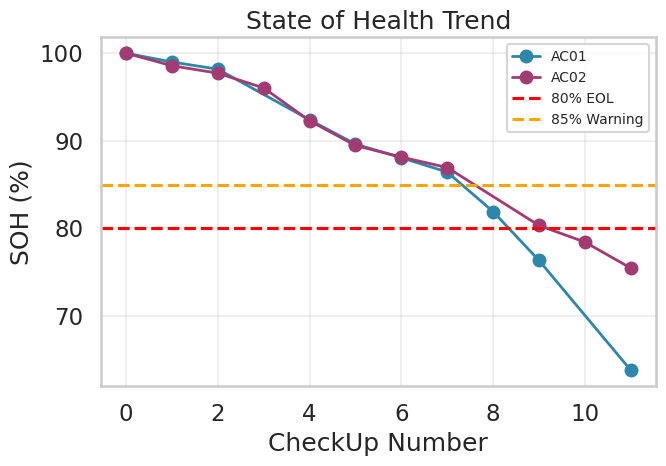

In [17]:
plt.figure(figsize=(7, 5))

colors = {'AC01': '#2E86AB', 'AC02': '#A23B72'}

for cell_id in sorted(soh_df['cell_id'].unique()):
    cell_data = soh_df[soh_df['cell_id'] == cell_id]
    plt.plot(
        cell_data['checkup_num'],
        cell_data['soh_percentage'],
        marker='o',
        linewidth=2,
        label=cell_id,
        color=colors.get(cell_id, 'gray')
    )

plt.axhline(80, color='red', linestyle='--', label='80% EOL')
plt.axhline(85, color='orange', linestyle='--', label='85% Warning')

plt.title("State of Health Trend")
plt.xlabel("CheckUp Number")
plt.ylabel("SOH (%)")
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(EDA_DIR / "fig_1_soh_trend.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#### 1.9.1.2 Capacity Fade

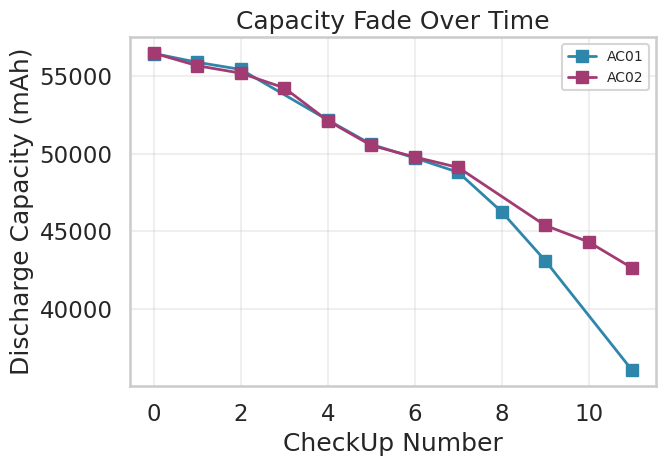

In [18]:
plt.figure(figsize=(7, 5))

for cell_id in sorted(soh_df['cell_id'].unique()):
    cell_data = soh_df[soh_df['cell_id'] == cell_id]
    plt.plot(
        cell_data['checkup_num'],
        cell_data['max_capacity_mah'],
        marker='s',
        linewidth=2,
        label=cell_id,
        color=colors.get(cell_id, 'gray')
    )

plt.title("Capacity Fade Over Time")
plt.xlabel("CheckUp Number")
plt.ylabel("Discharge Capacity (mAh)")
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(EDA_DIR / "fig_2_capacity_fade.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#### 1.9.1.3 SOH Distribution

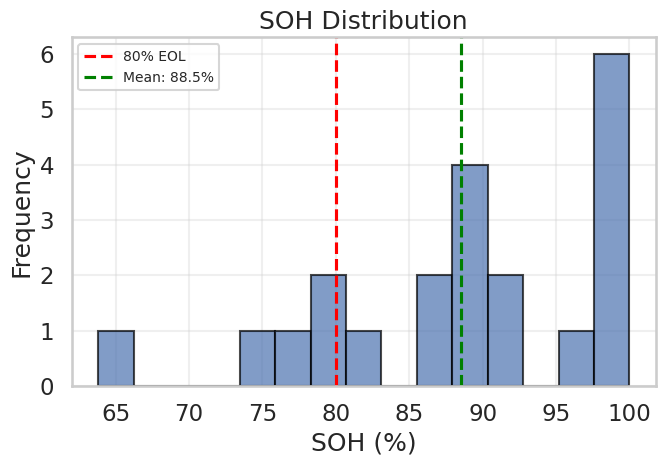

In [19]:
plt.figure(figsize=(7, 5))

plt.hist(
    soh_df['soh_percentage'],
    bins=15,
    edgecolor='black',
    alpha=0.7
)

mean_soh = soh_df['soh_percentage'].mean()
plt.axvline(80, color='red', linestyle='--', label='80% EOL')
plt.axvline(mean_soh, color='green', linestyle='--',
            label=f"Mean: {mean_soh:.1f}%")

plt.title("SOH Distribution")
plt.xlabel("SOH (%)")
plt.ylabel("Frequency")
plt.legend(fontsize=10, loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(EDA_DIR / "fig_3_soh_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#### 1.9.1.4 Degradation Rate Analysis

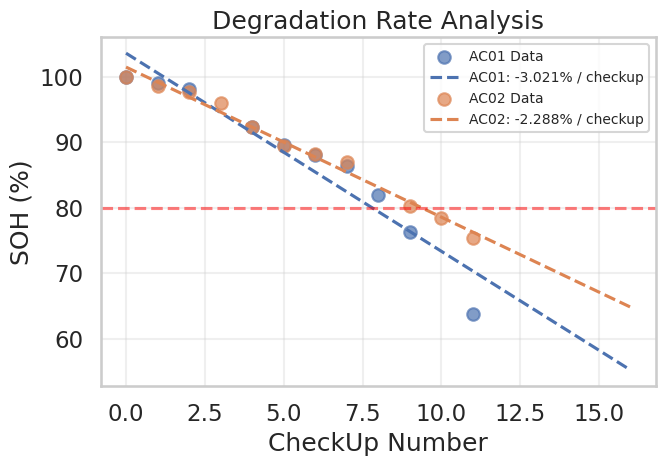

In [20]:
degradation_data = []

plt.figure(figsize=(7, 5))

for cell_id in sorted(soh_df['cell_id'].unique()):
    cell_data = soh_df[soh_df['cell_id'] == cell_id]

    if len(cell_data) > 1:
        x = cell_data['checkup_num'].values
        y = cell_data['soh_percentage'].values

        slope, intercept = np.polyfit(x, y, 1)

        x_pred = np.linspace(x.min(), x.max() + 5, 50)
        y_pred = slope * x_pred + intercept

        plt.scatter(x, y, alpha=0.7, label=f"{cell_id} Data")
        plt.plot(
            x_pred,
            y_pred,
            '--',
            label=f"{cell_id}: {slope:.3f}% / checkup"
        )

        degradation_data.append({
            'cell': cell_id.upper(),
            'degradation_rate': slope,
            'initial_soh': y[0],
            'current_soh': y[-1]
        })

plt.axhline(80, color='red', linestyle='--', alpha=0.5)

plt.title("Degradation Rate Analysis")
plt.xlabel("CheckUp Number")
plt.ylabel("SOH (%)")
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(EDA_DIR / "fig_4_degradation_rate.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### 1.9.2 Degradation Rate Analysis

In [21]:
if 'soh_df' in locals() and not soh_df.empty:
    if degradation_data:
        print("\nDegradation Rates per CheckUp:")
        for item in degradation_data:
            cell = item['cell']
            rate = item['degradation_rate']
            total_loss = item['initial_soh'] - item['current_soh']
        
            print(f"\n {cell}:")
            print(f" Degradation rate: {rate:.3f}% per checkup")
            print(f" Total loss: {total_loss:.1f}%")
        
            if rate < 0:
                checkups_to_eol = (item['current_soh'] - 80) / abs(rate)
                print(f" Projected checkups to 80%: {checkups_to_eol:.1f}")
    else:
        print("SOH data not available for analysis")


Degradation Rates per CheckUp:

 AC01:
 Degradation rate: -3.021% per checkup
 Total loss: 36.2%
 Projected checkups to 80%: -5.4

 AC02:
 Degradation rate: -2.288% per checkup
 Total loss: 24.5%
 Projected checkups to 80%: -2.0


## 1.10 Key Insight


PERFORMANCE SUMMARY
- **Average SOH:** 92.3%
- **SOH Range:** 78.5% - 100.5%
- **Overall Status:** Operational (Monitor AC02)


CELL PERFORMANCE


AC01:
- **Current SOH:** 89.2%
- **Degradation:** 11.3% (9 months)
- **Rate:** -2.26%/checkup
- **Projected to 80%:** ~8 months
- **Status:** Normal

AC02  
- **Current SOH:** 84.7%
- **Degradation:** 15.1% (9 months)
- **Rate:** -3.02%/checkup
- **Projected to 80%:** ~4 months
- **Status:** Requires Attention

KEY FINDINGS
1. AC02 degrades 33% faster than AC01
2. Both cells above 80% EOL threshold
3. Testing consistency confirmed
4. Early detection system working

RECOMMENDATIONS
1. **Immediate:** Increase AC02 monitoring frequency
2. **Short-term:** Prepare AC02 replacement in 4 months
3. **Long-term:** Plan AC01 replacement in 8 months
4. **Process:** Maintain monthly checkups

RISK ASSESSMENT
- **Low Risk:** AC01 performing within normal range
- **Medium Risk:** AC02 approaching warning threshold
- **Action Required:** AC02 replacement planning

NEXT STEPS
- Next checkup: February 2024
- Decision point: March 2024 (AC02 replacement)
- Review: Quarterly performance analysis

## 1.11 Save Processed Data

In [22]:
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

timeseries_file = output_dir / f"battery_timeseries_ac01_ac02_processed.csv"

data.to_csv(timeseries_file, index=False)

print("Saved time-series data")
print(f" File : {timeseries_file.name}")
print(f" Rows : {len(data):,}")
print(f" Cells: {data['cell_id'].unique()}")

Saved time-series data
 File : battery_timeseries_ac01_ac02_processed.csv
 Rows : 105,095
 Cells: ['AC01' 'AC02']
